<a href="https://colab.research.google.com/github/kekys778/NLP_HSE/blob/main/DONE_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Домашка №1
# Усложненная
### Эта домашка нужна для лучшего понимания, но она будет сложнее из-за использования классов и, возможно, пока непривычной форме с классами.
Абстракции в этой домашке будут очень полезны для понимания того, что происходит в торче. Эта домашка прокачает вас гораздо сильнее, но и выполнить ее будет труднее. Вам нужно будет описать несколько слоев: `Linear`, `ReLU`, `BCELoss`.  Реализация `Sigmoid` уже есть в `our_library.layers`. Реализовав слои выше вы сможете сделать n-слойную нейронную сеть с любым количеством слоев. Это получается за счет того, что вы описали всю необходимую логику:
- Как нужно обработать входные данные и передать их дальше;
- Принять градиент с последующего слоя, сделать `backward` для текущего слоя и передать градиент предыдущему слою;
- Как обновить веса, если в слоев есть обучаемые веса.

Присылайте свои недоделанные сложные домашки, пусть они не пойдут совсем в стол. Я или ассистенты посмотрят, мы обсудим и доделаем.  
Поверьте, эта домашка стоит того, чтобы ее сделать!

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Некоторые магические трансформации, о которых пока не стоит заморачиваться
1. Перевод картинки в тензор
1. Нормализация картинки

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет
Конкретно эта часть кода понадобится нам один раз за курс и будет только в этой домашке

In [ ]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса
Это нужно для упрощения задачи до бинарной классификации. В этой домашке мы будем отличать две цифры: 1 и 7.

In [ ]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных
Далее в курсе мы поговорим о том, что это такое более подробно, а дальше в этой тетрадке будет несколько полезных деталей.  
Пока что будет достаточно понимать, что мы обернули наши данные в некоторую абстракцию, итерация по которой дает нам батчи данных из нашего датасета.  

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7  

Выбрал эти цифры, потому что на них хуже всего метрики

Epoch 1:   0%|          | 0/97 [27:20<?, ?it/s]


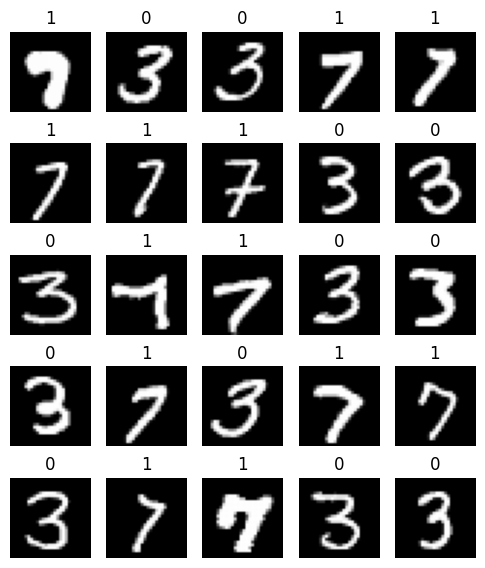

In [ ]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Итерация по датасету
- x - батч с данными
- y - батч с таргетами к этим данным

In [ ]:
for x, y in train_loader:
    break

### train_loader это итератор, при проходе по которому будут выдаваться батчи данных

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [ ]:
x.shape

torch.Size([128, 1, 28, 28])

In [ ]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### То есть каждая фича в векторе это значение пикселя
### Для нашей игрушечной задачи этого будет достаточно

In [ ]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

### x.numpy()
Это перевод торчового тензора (некоторая абстракция, о которой мы будем говорить позже на курсе) в numpy массив

In [ ]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [ ]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [ ]:
x.shape

(128, 784)

# Таргеты
- классу 0 соответствует цифра 3
- классу 1 соответствует цифра 7

In [ ]:
y

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1])

# Итерация по эпохам

In [ ]:
# количество эпох - полных проходов по датасету
epochs = 3

for n_epoch in range(epochs):

    dataset_passed_samples = 0

    for x, y in train_loader:

        # вот здесь мы могли бы как-то манипулировать с данными
        # например, учить, но пока этого делать не будет
        # только демонстрация

        time.sleep(0.01)

        dataset_passed_samples += x.shape[0]

        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]

        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')

    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Небольшие пояснения по numpy

In [ ]:
# таким образом мы создаем матрицу 64 на 512 с рандомными значениями
x = np.random.rand(64, 512)
x

array([[0.44991489, 0.45500567, 0.64558199, ..., 0.37599229, 0.39215407,
        0.95452544],
       [0.18488994, 0.47828979, 0.18449583, ..., 0.280529  , 0.39987993,
        0.90814814],
       [0.37070258, 0.78079071, 0.55945229, ..., 0.60315824, 0.14855696,
        0.75166924],
       ...,
       [0.73137954, 0.11837606, 0.59701729, ..., 0.67603742, 0.47377412,
        0.09331891],
       [0.11387578, 0.36217781, 0.97102998, ..., 0.41853195, 0.25299677,
        0.60343684],
       [0.71572517, 0.42642704, 0.89450552, ..., 0.42131921, 0.55877319,
        0.35228923]])

In [ ]:
# большинство функций применяются к каждому элементу массива
# здесь мы каждый элемент массива возвели в квадрат и прибавили к получившемуся значению логарифм элемента матрицы
x ** 2 + np.log(x)

array([[-0.59627342, -0.58041525, -0.02082694, ..., -0.83681644,
        -0.78231567,  0.86457783],
       [-1.65381024, -0.50877734, -1.65608971, ..., -1.19238164,
        -0.756687  ,  0.72838528],
       [-0.85493482,  0.362186  , -0.26781017, ..., -0.14177583,
        -1.88471763,  0.27954776],
       ...,
       [ 0.22209328, -2.11987585, -0.15937955, ...,  0.06551976,
        -0.52256269, -2.36302411],
       [-2.15967935, -0.88444723,  0.91350128, ..., -0.69583307,
        -1.31037121, -0.14097789],
       [ 0.17780348, -0.67047398,  0.68865591, ..., -0.68685465,
        -0.26978416, -0.91919507]])

In [ ]:
y = np.random.rand(512, 1024)
# скалярное произведение
res = np.dot(x, y)

In [ ]:
res

array([[131.77730079, 133.47813135, 129.43864472, ..., 131.52007595,
        127.76482888, 133.01463735],
       [131.0952977 , 136.58765165, 133.55943945, ..., 134.57047635,
        127.99521984, 136.85485115],
       [133.53664838, 137.85422684, 132.54694784, ..., 131.92708688,
        126.87195972, 135.10515061],
       ...,
       [131.27119009, 136.29255681, 133.71643011, ..., 130.6069237 ,
        129.17002746, 131.95853973],
       [127.1970093 , 134.5211067 , 126.13861393, ..., 125.38233754,
        123.37606171, 127.81586624],
       [138.461871  , 140.16909102, 142.0872123 , ..., 136.3010094 ,
        131.42614268, 139.64734856]])

In [ ]:
res.shape == (x.shape[0], y.shape[1])

True

# Импортируем нашу библиотеку
В ней реализованы некоторые полезные методы, в модуле `layers` есть реализация сигмоиды. Остальное вам смотреть необязательно, это некоторые дополнения, упрощающие вам жизнь.

In [ ]:
!git clone https://github.com/zelcookie/from-numpy-import-Neural-Network.git
import sys
sys.path.append("/content/from-numpy-import-Neural-Network/")

fatal: destination path 'from-numpy-import-Neural-Network' already exists and is not an empty directory.


In [ ]:
from our_library import layers, wrapper, tools

In [ ]:
layers.Sigmoid??

## Реализуйте слои:
- Linear - линейная трансформация (не забудьте, что у нас в этом слое как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файла layers

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, 1)

## Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом) для примера

# Пример c сигмоидой
В `our_library.layers` также это есть

In [ ]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):

        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """

        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_step):

        pass

# Тестирование

In [ ]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [ ]:
sigmoid_layer = Sigmoid()
forward_result = sigmoid_layer.forward(x)
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward_result)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward_result)

# Линейный слой

In [ ]:
class Linear:

    def __init__(self, in_features, out_features):

        # инициализируем веса
        self.weight = np.random.randn(in_features, out_features) * 0.01 # (in_f, out_f)
        self.bias = np.zeros(out_features) # (1, out)

        # сохраняем градиент для весов
        self._grad_weight = None
        self._grad_bias = None

    def forward(self, x):
        self._x = x # (b, in_f)
        y = x @ self.weight + self.bias # (b, in_f) x (in_f, out_f) --> (b, out_f)
        return y


    def backward(self, grad):
        """значит нам тут приходит градиет с предыдущих слоев
        что бы понять, как изменять веса, нам нужно умножить вот этот градиент на вход
        """
        self._grad_weight = self._x.T @ grad  #  @ (in_f, b) @ (b, out_f) -- > (in_f, out_f)
        self._grad_bias = grad.sum(axis = 0)

        return grad @ self.weight.T # (b, out_f) x (out_f, in_f)

    def step(self, learning_rate):
        self.weight = self.weight - learning_rate * self._grad_weight
        self.bias = self.bias - learning_rate * self._grad_bias


# Тестирование

In [ ]:
correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ],
                          [0.73044998, 0.18287682, 0.41246361]])

correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165],
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [ ]:
linear = Linear(in_features=4, out_features=3)

In [ ]:
# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weight = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [ ]:
forward = linear.forward(x)
backward = linear.backward(previous_grad)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

In [ ]:
# значения должны быть близкими
assert np.allclose(linear._grad_weight, correct_grad_weight)

In [ ]:
linear._grad_weight

array([[0.60719574, 0.92790321, 1.24830165],
       [0.08968325, 0.15020214, 0.19972094],
       [0.22889674, 0.71103859, 0.89213814],
       [0.14874632, 0.54024567, 0.67098608]])

In [ ]:
correct_grad_weight

array([[0.60719574, 0.92790321, 1.24830165],
       [0.08968325, 0.15020214, 0.19972094],
       [0.22889674, 0.71103859, 0.89213814],
       [0.14874632, 0.54024567, 0.67098608]])

In [ ]:
# значения должны быть близкими
assert np.allclose(linear._grad_bias, correct_grad_bias)

# ReLU

In [ ]:
class ReLU:

    def forward(self, x):
        self._x = x

        return np.maximum(0, x)

    def backward(self, prev_grad):
        grad  = prev_grad * (self._x > 0)

        return grad

# Тестирование

In [ ]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [ ]:
relu = ReLU()

In [ ]:
forward = relu.forward(x)
backward = relu.backward(previous_grad)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

# BCE test

### Не забудьте добавить np.expand_dims(y, 1) в forward

In [ ]:
class BCELoss:

    def __init__(self):
        self.loss_result = None

    def forward(self, x, y):
        self.x = x
        self.y = np.expand_dims(y, 1)
        loss = np.mean(-(self.y * np.log(x + 1e-9) + (1 - self.y) * np.log(1 - x + 1e-9)))
        return loss

    def backward(self):

        grad = (-(self.y / (self.x + 1e-9)) + ((1 - self.y) / (1 - self.x + 1e-9))) / len(self.y)
        return grad
    def step(self, learning_rate):
        pass

# Тестирование

In [ ]:
x = np.array([[0.76242307],
              [0.0908412 ],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

correct_forward_result = 0.24384403491500606

correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [ ]:
np.expand_dims(y, 1)

array([[1],
       [0],
       [1],
       [0]])

In [ ]:
loss = BCELoss()

In [ ]:
forward = loss.forward(x, y)
backward = loss.backward()

In [ ]:
backward

array([[-0.32790193],
       [ 0.27497946],
       [-0.41544356],
       [ 0.27656947]])

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_forward_result, forward)

In [ ]:
# значения должны быть близкими
assert np.allclose(correct_backward_result, backward)

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: обновление весов можно сделать циклом
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward, то есть последний слой нашей сети
- TIP 5: forward и backward ничего не должны отдавать, в них должны быть расчитаны градиенты для каждого слоя
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

In [ ]:
class NeuralNetwork:

    def __init__(self, modules):

        # список слоев
        self.modules = modules #[Linear, ReLU, Linear, Sigmoid]

    def forward(self, x):
        for module in self.modules:
            x = module.forward(x)
        return x


    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """
        for module in reversed(self.modules):
            grad = module.backward(grad)
        return x

    def step(self, learning_rate):

        self.modules[0].step(learning_rate)
        self.modules[2].step(learning_rate)

## Реализуйте обертку над моделью

In [ ]:
class MNISTWrapper(wrapper.Wrapper):

    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели, передавая туда значение градиента по функции потерь
        5. Обновление весов с помощью step
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """
        # КОД ЗДЕСЬ

        prediction = self.model.forward(x)

        loss_value = self.loss.forward(prediction, y)
        grad_loss = self.loss.backward()

        self.model.backward(grad_loss)
        self.model.step(self.learning_rate)

        return loss_value, prediction


In [ ]:
# задайте гиперпараметры
learning_rate = 0.01
epochs = 2

# задайте слои в свою нейронную сеть, например, 3 слоя
neural_network = NeuralNetwork([
   Linear(784, 128),
    ReLU(),
    Linear(128, 1),
    Sigmoid()
])

loss = BCELoss()

In [ ]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)


## Обучение модели

In [ ]:
classifier.train(train_loader, test_loader, epochs=10)

Epoch 10: 100%|██████████| 97/97 [00:05<00:00, 18.80it/s, loss=0.0483, metric=0.985]


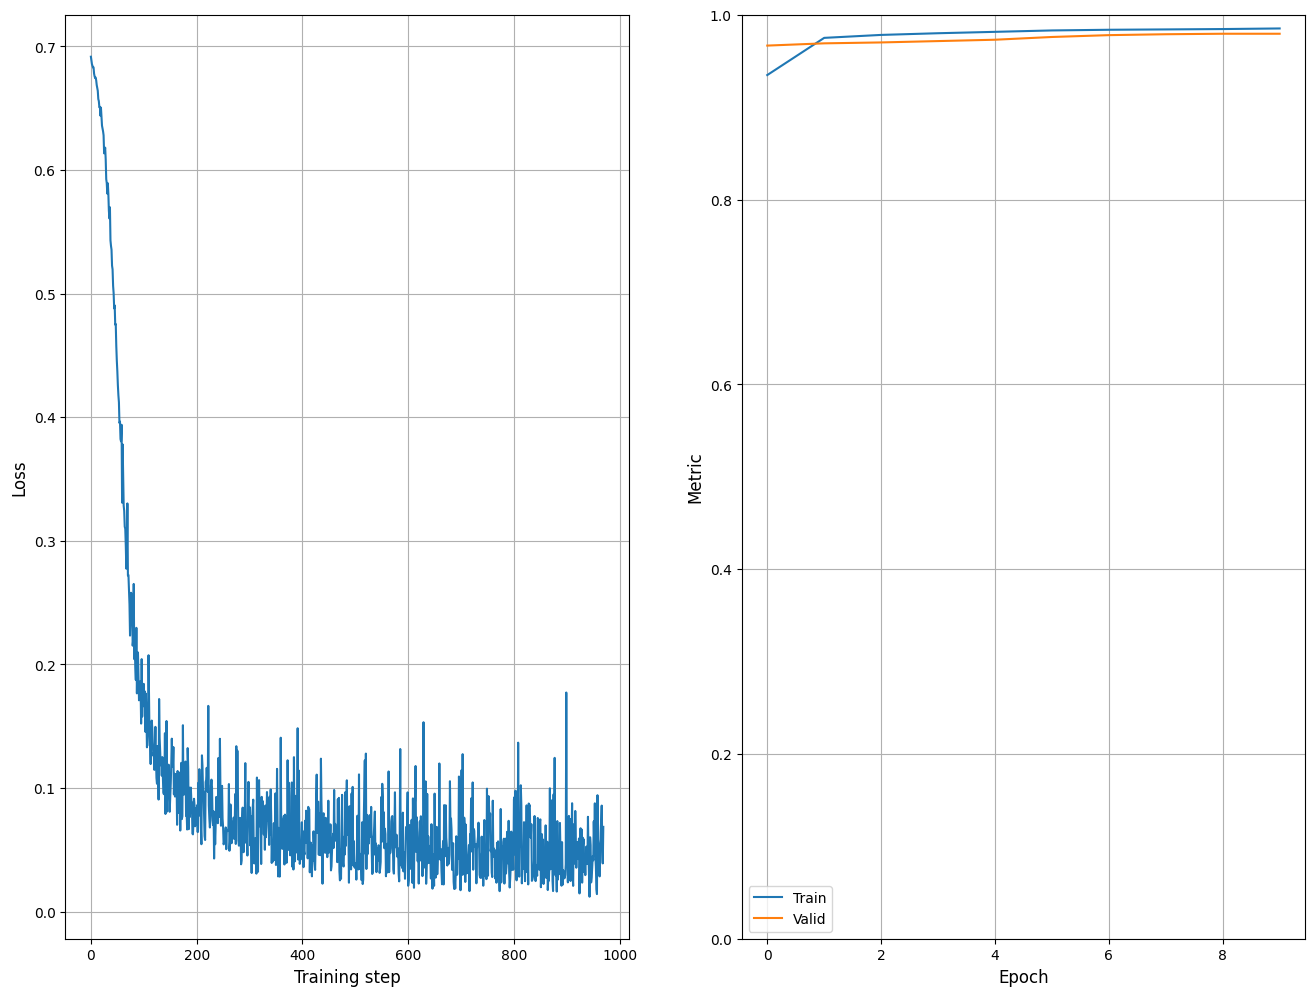

In [ ]:
classifier.plot()

In [ ]:
import numpy as np
# а тут просто решение квадратных уравнений при помощи градиента

In [ ]:
w_1 = 0

eq = w_1^2+5*w_1-4
target = 3
best_loss = float('inf')
prev_grad = 0
grad = 0
loss = float('inf')
prev_w = 0
lr = 0.01
loss_cnt = 0
grad_cnt = 0
iter_cnt = 0
prev_loss = float('inf')
max_iter = 100

def calculate_loss(target, y):
  return np.abs(target - y)

def calculate_grad(w_1, target, y):

  return np.sign(y - target) * (2*w_1 + 5)


while True:

  iter_cnt+=1
  prev_grad = grad
  prev_w = w_1
  prev_loss = loss

  y = w_1*w_1 + 5*w_1 - 4
  loss = calculate_loss(target, y)

  grad = calculate_grad(w_1, target, y)

  w_1 = prev_w - lr*grad


  if best_loss > loss:
    best_loss = loss
    best_w = w_1
  print(f'cur_loss: {round(loss, 2)}, prev_loss: {round(prev_loss, 2)}')
  print(f'cur_y: {y}')
  print((f'cur_grad: {grad}, prew_gard: {prev_grad}'))
  print((f'cur_w_1: {w_1}, prew_w: {prev_w}\n'))

  print((f'best_loss: {best_loss}, best_w: {best_w}\n'))

  if abs(grad - prev_grad) < 0.001:
    grad_cnt+=1

  if loss - prev_loss > 0.001:
    loss_cnt+=1

  if grad_cnt > 3 or loss_cnt > 3 or iter_cnt > max_iter:
    break





In [ ]:
eq = w_1**2+5*w_1-4

In [ ]:
# РЕАЛИЗАЦИЯ НА ТОРЧЕ

import torch
import torch.optim

def find_best_x(target, lr):
    best_loss = float('inf')
    loss = float('inf')
    prev_loss = float('inf')
    loss_cnt = 0


    w_1 = torch.tensor(0.0, requires_grad=True)

    optimizer = torch.optim.SGD([w_1], lr=0.01)

    for i in range(100):

      optimizer.zero_grad()

      y = w_1**2+5*w_1-4

      prev_loss = loss

      loss = abs(target - y)

      loss.backward()

      optimizer.step()


      if best_loss > loss:

        best_loss = loss

      if prev_loss < loss:

        loss_cnt += 1


      print(f"iter {i}: w={w_1.item():.4f}, loss={loss.item():.4f}")

      # if loss_cnt > 3:
      #   print(f'best_loss : {best_loss}')
      #   break

In [ ]:
find_best_x(5, 0.1)